# **Packages and Formatting**

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm

In [2]:
# Import Save the Children color palette

sc_colors = {'red': '#da291c',
             'medium red' : '#ed7b73',
             'light red': '#f9d3d0',
             'purple': '#ae90c3',
             'medium purple': '#cebcdb',
             'light purple': '#efe9f3',
             'yellow': '#fecf28',
             'medium yellow': '#ffeca9',
             'light yellow': '#fff5d4',
             'blue': '#99cccc',
             'medium blue' : '#d6ebeb',
             'light blue' : '#ebf5f5',
             'green' : '#45b283',
             'medium green' : '#8dd3b5',
             'light green' : '#d9f0e6',
             'grey' : '#e7e6e6'}

mpl.rcParams['font.family'] = 'Calibri' 

# **Helper Functions**

In [119]:
# -----------------------------
# Helper functions
# -----------------------------

def cronbach_alpha(df: pd.DataFrame) -> float:
   
    df = df.dropna(how="any")
    k = df.shape[1]
    
    var_items = df.var(axis=0, ddof=0).sum()
    var_total = df.sum(axis=1).var(ddof=0)

    if var_total == 0:
        return np.nan
    
    alpha = (k / (k - 1)) * (1 - var_items / var_total)

    return alpha

def print_per_grade(res, label="Model"):

    b = res.params["Grade"]
    se = res.bse["Grade"]

    # 95% CI (normal approx)
    ci_low = b - 1.96 * se
    ci_high = b + 1.96 * se
    print(f"\n[{label}] SD-units per grade:")
    print(f"  Beta_grade = {b: .3f}")
    print(f"  95% CI     = [{ci_low: .3f}, {ci_high: .3f}]")

# **Import and Prepare Data**

In [50]:
df = pd.read_csv(r"C:\Users\FTurner\OneDrive - Save the Children UK\Documents\06 Random Python Files\SLEIC Analysis\2025 Results Blog\Data\aser_baseline_clean.csv")

In [ ]:
#============================================================
# Create numeracy mean and z-score
#============================================================

# Numeracy domains (ignore 'Literacy mean')
numeracy_cols = [
    "Number Recognition mean",
    "Addition Mean",
    "Subtraction mean",
    "Multiplication mean",
    "Division mean",
]

# Coerce numeracy to numeric
for c in numeracy_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Create numeracy mean and z-score
df["numeracy_mean"] = df[numeracy_cols].mean(axis=1)
df["z"] = (df["numeracy_mean"] - df["numeracy_mean"].mean()) / df["numeracy_mean"].std(ddof=0)

# Print min/max of numeracy mean and Cronbach's alpha for sanity check on data

print("Numeracy mean: min/max =", df["numeracy_mean"].min(), df["numeracy_mean"].max())
alpha = cronbach_alpha(df[numeracy_cols])
print(f"Cronbach's alpha (numeracy domains): {alpha: .3f}")

#============================================================
# Clean and prepare data for key covariates
#============================================================

# Remove age outliers
df["age_outlier"] = (df["Age"] < 4) | (df["Age"] > 18)
df = df[~df["age_outlier"]]
df = df.drop(columns=["age_outlier"])

# Grade as integer
df["Grade"] = df["Grade"].astype(str).str.strip()
df["Grade"] = df["Grade"].replace({"Class 1": 1, "Class 2": 2, "Class 3": 3, "Class 4": 4, "Class 5": 5, "Class 6": 6})
df["Grade"] = df["Grade"].astype("int64")
# Age as integer
df["Age"] = df["Age"].astype('int64')
# Clean sex column
df["Sex"] = df["Sex"].astype(str)
df["Sex"] = df["Sex"].str.strip().replace({"nan": np.nan, "": np.nan})

# Drop rows with missing key covariates
df = df.dropna(subset=["numeracy_mean", "Sex", "Grade", "Age", "school_code"])

# **2. Calculate Grade Effect**


In [ ]:
#===========================================================================
# Run Mixed-Effects Model with Random Intercepts + Random Slopes for Grade
#===========================================================================

m_mixed_rs = mixedlm("z ~ Grade + Age + C(Sex)", df, groups=df['school_code'], re_formula="1 + Grade")
res_mixed_rs = m_mixed_rs.fit(method="lbfgs")

print("\n[Mixed-effects: random intercepts + random slopes (Grade)] summary:")
print(res_mixed_rs.summary())
print_per_grade(res_mixed_rs, label="Mixed-effects (RI+RS)")




[Mixed-effects: random intercepts + random slopes (Grade)] summary:
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  z         
No. Observations:    1536     Method:              REML      
No. Groups:          65       Scale:               0.2932    
Min. group size:     15       Log-Likelihood:      -1383.6032
Max. group size:     30       Converged:           Yes       
Mean group size:     23.6                                    
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         -1.802    0.087 -20.653 0.000 -1.973 -1.631
C(Sex)[T.Male]     0.129    0.028   4.618 0.000  0.074  0.184
Grade              0.347    0.022  15.755 0.000  0.303  0.390
Age                0.057    0.010   5.591 0.000  0.037  0.076
Group Var          0.224    0.098                            
Group x Grade

### **Description of Results**

Each additional grade level is associated with a 0.347 standard deviation increase in numeracy scores (95% CI: 0.303–0.390), highly statistically significant (p<0.001). This represents substantial learning gains approximately every grade transition. The random slopes variance (0.017) indicates some school-level variation in grade effects, i.e., some schools show steeper or shallower learning trajectories than others.

**Variance Components:**

- Residual (individual): **0.293**
- School clustering: **0.224**
- Grade random slopes: **0.017**
- Total: **0.534**

**Proportions:**

- Individual variance: **54.9%**
- School/clustering variance: **41.9%**
- Grade slope variation: **3.2%**
- Intraclass Correlation (ICC): 0.224 / (0.224 + 0.293) = **0.433**

This means 43% of numeracy score variation is attributable to school effects, which is a substantial clustering effect. Students within the same school are much more similar to each other than to students in other schools. The remaining 55% is individual-level variation. This high ICC justifies using a mixed-effects model with school random effects rather than treating observations as independent.

# **3. Test Assumption of Local Linearity**

In [105]:
#============================================================
# Run Mixed-Effects Model with Grade as Categorical Variable
#============================================================

m_mixed_rs = mixedlm("z ~ C(Grade) + Age + C(Sex)", df, groups=df['school_code'], re_formula="1 + Grade")
res_mixed_rs_gradecat = m_mixed_rs.fit(method="lbfgs")

print("\nMixed-effects: random intercepts + random slopes (Grade as Category) \n\nSummary:\n")
print(res_mixed_rs_gradecat.summary())


Mixed-effects: random intercepts + random slopes (Grade as Category) 

Summary:

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  z         
No. Observations:    1536     Method:              REML      
No. Groups:          65       Scale:               0.2913    
Min. group size:     15       Log-Likelihood:      -1384.2469
Max. group size:     30       Converged:           Yes       
Mean group size:     23.6                                    
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         -1.393    0.091 -15.235 0.000 -1.573 -1.214
C(Grade)[T.2]      0.230    0.052   4.387 0.000  0.127  0.333
C(Grade)[T.3]      0.687    0.065  10.571 0.000  0.559  0.814
C(Grade)[T.4]      1.071    0.080  13.307 0.000  0.913  1.229
C(Grade)[T.5]      1.304    0.095  13.786 0.000  1.119  1.490


In [108]:
#============================================================
# Extract and print grade step coefficients
#============================================================

model_params = res_mixed_rs_gradecat.params

step1 = model_params.iloc[1]
step2 = model_params.iloc[2]-model_params.iloc[1]
step3 = model_params.iloc[3]-model_params.iloc[2]
step4 = model_params.iloc[4]-model_params.iloc[3]
step5 = model_params.iloc[5]-model_params.iloc[4]

meanstep = np.mean([step1, step2, step3, step4, step5])
sdstep = np.std([step1, step2, step3, step4, step5])

print("Grade step coefficients:")
print(f" Step 1: {step1: .3f}")
print(f" Step 2: {step2: .3f}")
print(f" Step 3: {step3: .3f}")
print(f" Step 4: {step4: .3f}")
print(f" Step 5: {step5: .3f}")
print(f"\nAverage step: {meanstep: .3f}")
print(f"Standard deviation of steps: {sdstep: .3f}")
print(f"\nThe average step increase in z-scores per grade is approximately {meanstep:.3f}, the standard deviation of {sdstep:.3f} \nindicates some variability in the step sizes between grades, suggesting that the increase \nin numeracy scores is not perfectly linear across all grade transitions. \nHowever for indicative purposes this level of deviation is not a significant issue")

Grade step coefficients:
 Step 1:  0.230
 Step 2:  0.457
 Step 3:  0.385
 Step 4:  0.233
 Step 5:  0.438

Average step:  0.348
Standard deviation of steps:  0.098

The average step increase in z-scores per grade is approximately 0.348, the standard deviation of 0.098 
indicates some variability in the step sizes between grades, suggesting that the increase 
in numeracy scores is not perfectly linear across all grade transitions. 
However for indicative purposes this level of deviation is not a significant issue


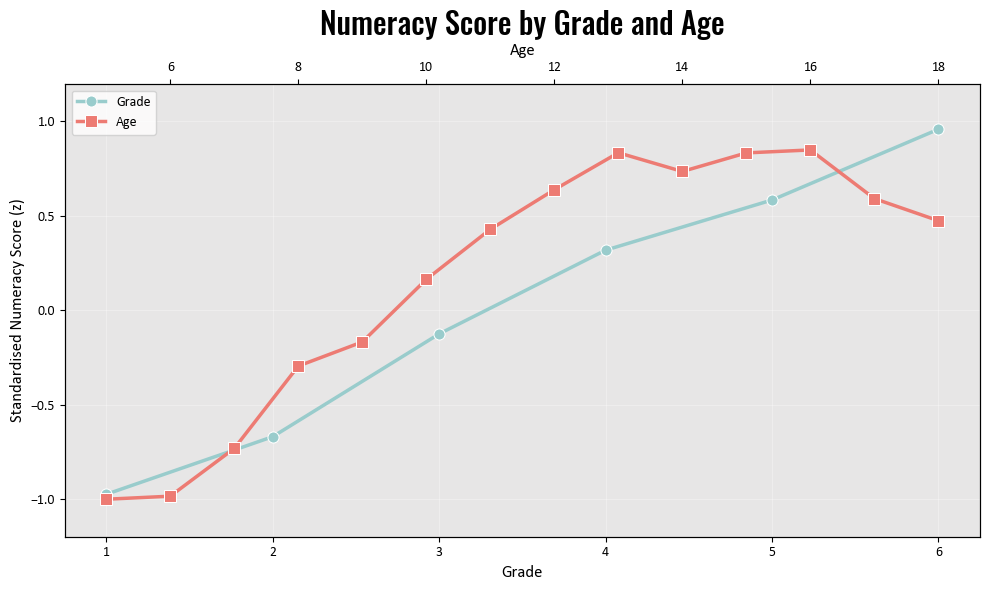

In [ ]:
#=============================================================================================
# Plot Grade and Age effects on numeracy z-scores to visualise linearity of grade effects
#=============================================================================================

fig, ax1 = plt.subplots(figsize=(10, 6))

# Prepare data for Grade
grade_summary = df.groupby('Grade')['z'].mean().reset_index()

# Plot Grade effect (bottom x-axis)
sns.lineplot(data=grade_summary, 
             x='Grade', 
             y='z', 
             marker='o', 
             linewidth=2.5, 
             markersize=8, 
             color=sc_colors['blue'], 
             label='Grade', 
             ax=ax1
             )

ax1.set_xlabel('Grade', fontsize=12)
ax1.set_ylabel('Standardised Numeracy Score (z)', fontsize=12)
ax1.grid(True, alpha=0.3, color='white')
ax1.patch.set_facecolor(sc_colors['grey'])

# Prepare data for Age
age_summary = df.groupby('Age')['z'].mean().reset_index()

# Mirror Age axis on top
ax2 = ax1.twiny()

# Plot Age effect (top x-axis)
sns.lineplot(data=age_summary, 
             x='Age', 
             y='z', 
             marker='s', 
             linewidth=2.5, 
             markersize=8, 
             color=sc_colors['medium red'], 
             label='Age', 
             ax=ax2
             )

ax2.set_xlabel('Age', fontsize=12)
ax2.legend().set_visible(False)

# Align y-axes and set limits
ax1.set_ylim(-1.2, 1.2)
ax2.set_ylim(-1.2, 1.2)

# Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Set title
ax1.set_title('Numeracy Score by Grade and Age', fontsize=22, fontname = 'Oswald')

# Display and export
plt.tight_layout()
plt.savefig('C:\\Users\\FTurner\\OneDrive - Save the Children UK\\Documents\\06 Random Python Files\\SLEIC Analysis\\2025 Results Blog\\Results\\numeracy_by_grade_and_age.png', dpi=300)
plt.show()
